

The training data are 2D coordinates, integer. Randomly generated.

With increasing number of coordinates,we want to find , since when ,the FNN start to generate fake coordinates.

Guess:
- The FNN will memorize if the learnable arguments (in number of floats) is around the same level of training data.

We use the diffusion model, the same as `ddpm2_emp_sample.ipynb`:
- Forward: $dX = dW$, given $X(0):= X_0$, $t \in [0,1]$,
- Backward: given $\bar{X}(0):=\mathcal{N}(0,I)$, $s \in [0,1]$
- Noise pixel-wise IID Gaussian;



In [11]:
import numpy as np
from pathlib import Path
from matplotlib import pyplot as plt
from sjldpm.apps.reference.rennet import call_by_inspect
import math
import numpy as np


logdir = Path("/home/tjrym/workspace/DDPM-SuJL/Results","ddpm2_emp_2d")
logdir.mkdir(parents=True,exist_ok=True)
logdir = logdir.as_posix()

# 超参数选择
T = 100

config = dict(locals())

Concept:

data, float matrix, (N,2);



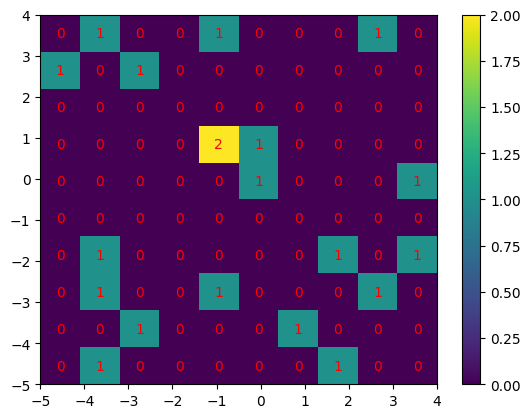

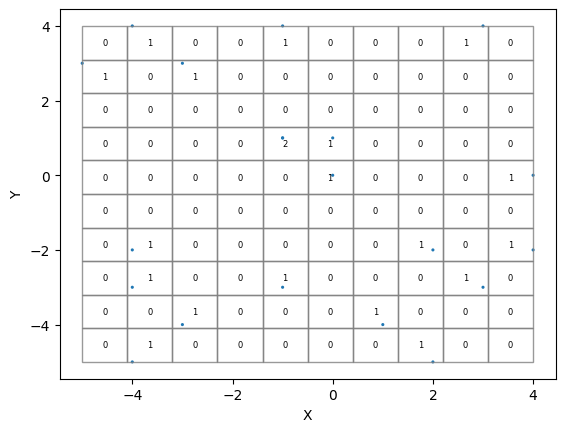

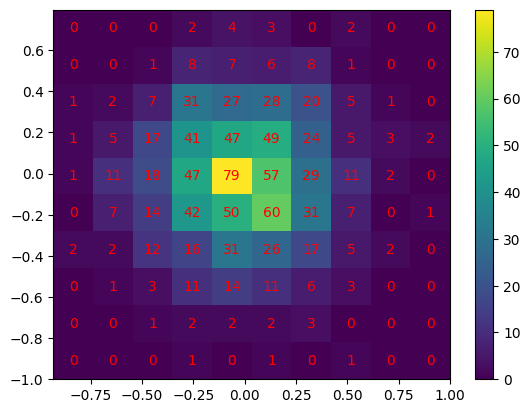

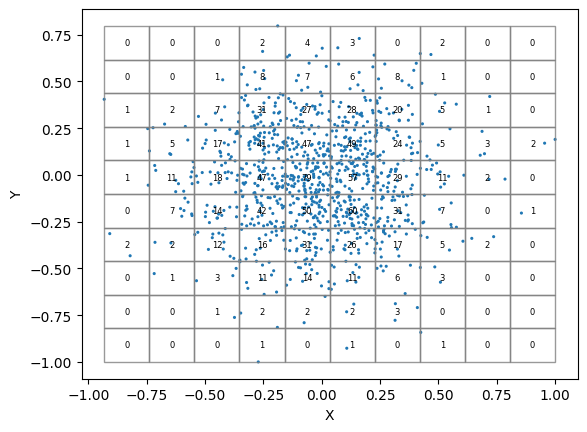

In [19]:
def make_raw_1(N, bound0,bound1):
    raw = np.random.randint(bound0,bound1,size = (N,2))
    return raw

def data_hist2d(anydata,*,logdir=None, suffix=None, nodisp=False):
    """
    anydata: (N,2)
    - Can be raw data or data
    """
    data = anydata

    hist, xedges, yedges = np.histogram2d(data[:,0],data[:,1])
    plt.hist2d(data[:,0],data[:,1])
    # add text labels to the plot
    dx = xedges[1]-xedges[0]
    dy = yedges[1]-yedges[0]
    for i in range(len(xedges)-1):
        for j in range(len(yedges)-1):
            plt.text(xedges[i]+0.5*dx, yedges[j]+0.5*dy, int(hist[i,j]),
                    color='red', ha='center', va='center')
    plt.colorbar()
    if not nodisp:
        plt.show()
    if logdir is not None:
        if suffix is not None:
            p = Path(logdir,f"data_hist2d__{suffix}.png")
        else:
            p = Path(logdir,f"data_hist2d.png")

        plt.savefig(p.as_posix())
        print(f"- save figure: {p}")
    plt.close()


def data_scatter2d(anydata,*,logdir=None, suffix=None, nodisp=False):
    """
    anydata: (N,2)
    - can be raw or data
    """
    data = anydata
    import numpy as np
    import matplotlib.pyplot as plt

    # generate some random 2D coordinates
    x = data[:,0]
    y=  data[:,1]

    # create a 2D histogram
    hist, xedges, yedges = np.histogram2d(x, y)

    # create a scatter plot of the 2D coordinates
    plt.scatter(x, y, s=5, alpha=1, edgecolor='none')

    # add boxes for each bin
    for i in range(len(xedges)-1):
        for j in range(len(yedges)-1):
            x1, y1 = xedges[i], yedges[j]
            x2, y2 = xedges[i+1], yedges[j+1]
            rect = plt.Rectangle((x1, y1), x2-x1, y2-y1, 
                                edgecolor='gray', facecolor='none', alpha=0.8)
            plt.gca().add_patch(rect)

            xc, yc = (x1 + x2) / 2, (y1 + y2) / 2
            count = hist[i,j]
            plt.text(xc, yc, int(count), ha='center', va='center', fontsize=6)

    # set the plot limits and labels
    xmin, xmax = np.min(x), np.max(x)
    ymin, ymax = np.min(y), np.max(y)
    plt.xlim(xmin, xmax)
    plt.ylim(ymin, ymax)
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.axis('tight')

    # show the plot
    if not nodisp:
        plt.show()
    if logdir is not None:
        if suffix is not None:
            p = Path(logdir,f"data_scatter2d__{suffix}.png")
        else:
            p = Path(logdir,f"data_scatter2d.png")

        plt.savefig(p.as_posix())
        print(f"- save figure: {p}")
    plt.close()
        
    return hist, xedges, yedges

def data_as_raw(data,bound0, bound1):
    raw = (data+1)/2*(bound1-bound0)+bound0
    return raw

def _test():
    _rdata = make_raw_1(20,-5,5)
    data_hist2d(_rdata)
    data_scatter2d(_rdata)

    
    # generate some random 2D coordinates
    x = np.random.normal(size=1000)
    y = np.random.normal(size=1000)
    data = np.stack([x,y],axis=1)
    data = (data-data.min())/(data.max()-data.min())*2-1
    data_hist2d(data)
    data_scatter2d(data)

_test()

The `raw`, refer to random ints (in this script), in [bound0, bound1];

The diffusion works on `data`, in [-1,1], mapped from `raw`

- data: shape  (100, 2)
- data min/max -64 61


100% 10/10 [00:00<00:00, 196.21it/s]s]
100%|██████████| 1/1 [00:00<00:00, 18.82bat/s]

- T= 10
- y0 min/max:  -1.0 1.0
## data
- dist_avr=0


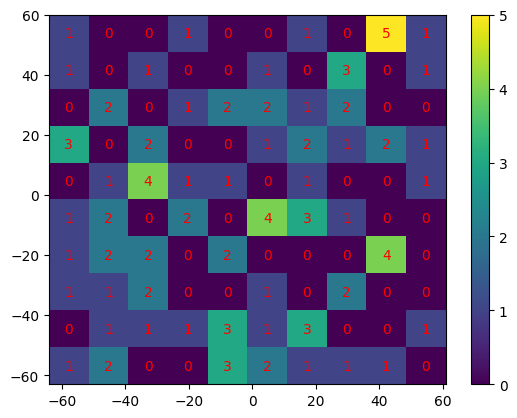

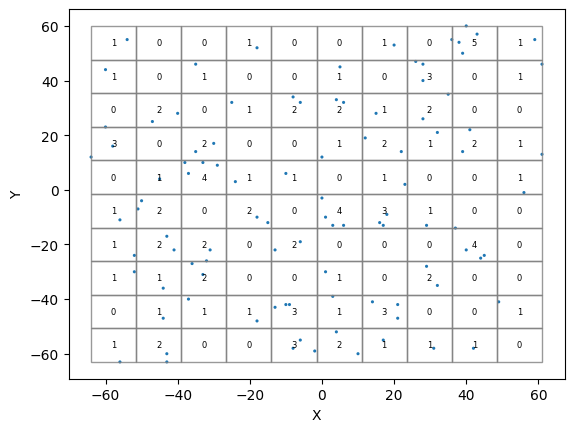

 ====
## samp_1
- dist_avr=0.16364137740480844


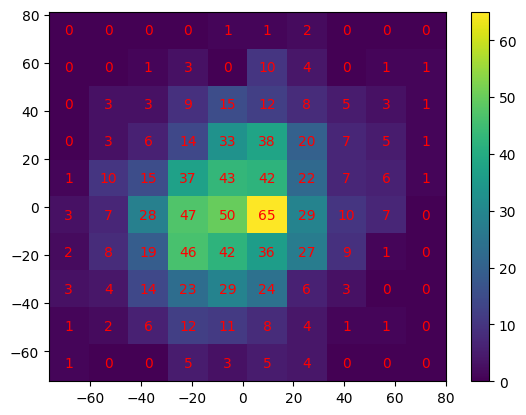

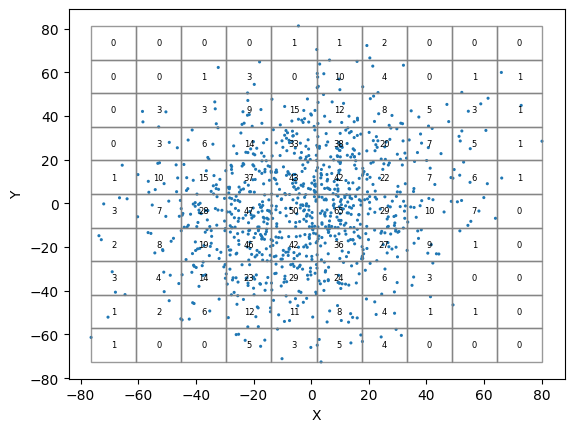

 ====
## samp_0.5
- dist_avr=0.16865113826718442


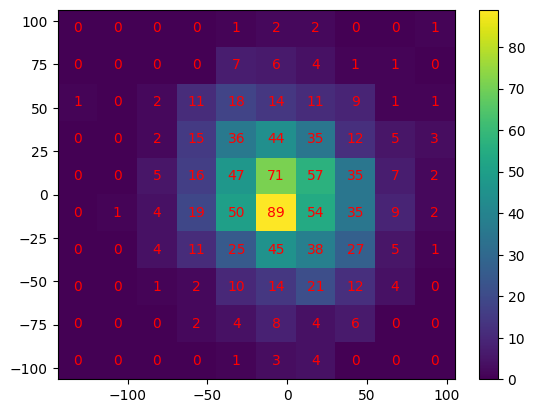

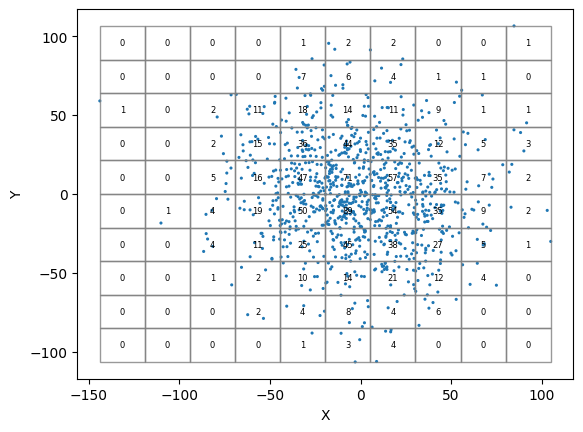

 ====
## samp_0
- dist_avr=0.16704654322559284


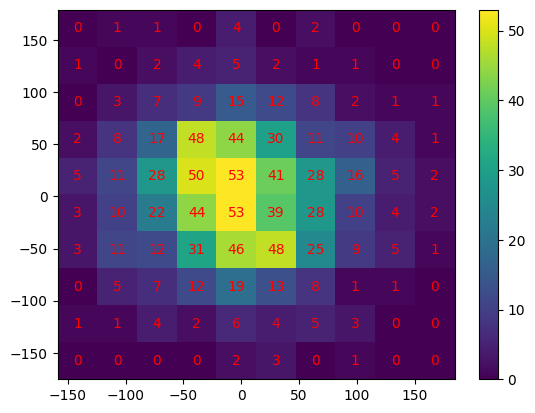

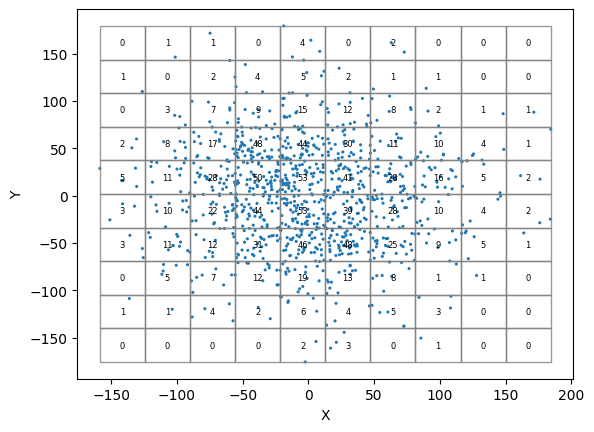

 ====


In [24]:
def score_function_1(t, x, data:np.ndarray):
    """
    - x: B,M
        + B: batch_size
    - data: N,M-array
        + N: number of partterns
        + M: number of dimensions
    - t: float
    """
    N = data.shape[0]
    M = data.shape[1]
    B = x.shape[0]

    assert x.shape[1] == data.shape[1], f"{x.shape[1]} neq {data.shape[1]}"

    data_ = data[np.newaxis,:,:] # 1NM
    x_ = x[:,np.newaxis,:] # B1M
    g = (x_-data_)**2 # BNM
    h = np.sum(g,axis=-1,keepdims=True)# BN1
    hmax = np.max(h,axis=1,keepdims=True)# B11
    v = np.sum( np.exp(h-hmax)*(x_-data_)/(-t), axis=1) # BM
    v =  v/np.sum(np.exp(h-hmax),axis=1)

    if data.shape[0]==1:
        assert np.sum(v - (x-data)/(-t))<1e-6, f"{np.sum(v)},\n{np.sum((x-data)/(-t))}"

    return v

def raw_as_data(raw,bound0,bound1):
    """
    """
    return (raw-bound0)/(bound1-bound0)*2-1

def data_as_raw(raw,bound0,bound1):
    return (raw+1)/2*(bound1-bound0)+bound0

from tqdm import tqdm,trange
def sample_1(data,T,batch_size, x0=None):
    """
    x0: None|Array(B,M)
    """
    M = data.shape[1]
    y_states = []

    if x0 is None:
        y = np.random.randn(batch_size, M) + 0 # xT \sim N(0,I)
    else:
        y = np.random.randn(batch_size, M) + x0 # xT \sim N(0,I)

    t_old = 0/T
    for i in tqdm(range(T), ncols=0):
        t = (i+1)/T # (1,...,T)/T
        # score_func_1
        sf=  score_function_1(1-t_old,y,data)
        y += sf *(t-t_old) + np.sqrt(t-t_old)* np.random.randn(*y.shape)
        y_states.append(y.copy())
        t_old = t
    
    return y_states


def run_1(N, bound0, bound1, T, n, batch_size,*,x0=None,nodisp=False,logdir=None):
    """
    Use N samples in data, generate n restored-states, in batch_size;
    Show grid of N_show and n_show;
    """
    raw = make_raw_1(N, bound0,bound1)
    assert bound0<= bound1
   
    M= raw.shape[1]
    print("- data: shape ",raw.shape)
    print("- data min/max" ,raw.min(), raw.max())
    data=  raw_as_data(raw,bound0,bound1)
    

    def batch_process(batch_size,x0):
        y_states = sample_1(data, T, batch_size, x0=x0)
        y0 = y_states[-1]
        y0 = np.clip(y0, -1, 1)
        print("- T=",T)
        print("- y0 min/max: ", y0.min(), y0.max())
        if x0 is not None:
            err = np.sum((y0-x0)**2)/y0.size
            print("- mse: ", err)
        
        return y0, y_states

    n_batch = math.floor(n/batch_size)
    y0_l =[]
    y_states_l=[]
    for ib in trange(n_batch,unit="bat"):
        if x0 is None:
            x0_b =None
        else:
            x0_b = x0[ib*batch_size:(ib+1)*batch_size]
        y0, y_states = batch_process(batch_size,x0=x0_b)
        y0_l.append(y0)
        y_states_l.append(y_states)
    if n%batch_size!=0:
        if x0 is None:
            x0_b =None
        else:
            x0_b = x0[(ib+1)*batch_size:]
        y0, y_states = batch_process(n%batch_size,x0=x0_b)
        y0_l.append(y0)
        y_states_l.append(y_states)
    
    y0=  np.concatenate(y0_l,axis=0) # (n,M)
    y_states = [np.concatenate([s[t] for s in y_states_l],axis=0) for t in range(len(y_states_l[0]))] # List-T,(n,M)

    def show_n_save(grid, title, func_name="run_1"):
        """
        grid= (coords, dist_avr)
        """
        coords, dist_avr = grid
        print(f"## {title}")
        print(f"- dist_avr={dist_avr}")
        data_hist2d(coords, logdir=logdir,suffix=f"{func_name}__{title}", nodisp=nodisp)  
        data_scatter2d(coords, logdir=logdir,suffix=f"{func_name}__{title}", nodisp=nodisp)
        print(" ====")

        

    def make_grid(data):
        """
        Retuen grid;
        
        grid:=tuple(coords, dist_var)
        
        """
        coords = data_as_raw(data, bound0, bound1)

        dist_avr= 0
        for i in range(coords.shape[0]):
            c = coords[i,:]
            cr = np.round(c) # M
            dist_avr += np.sum((c-cr)**2)
        dist_avr /= coords.shape[0]
        return coords, dist_avr

    show_n_save((raw,0),"data")
    show_n_save(make_grid(y_states[-1]),"samp_1")
    show_n_save(make_grid(y_states[round(len(y_states)/2)]),"samp_0.5")
    show_n_save(make_grid(y_states[0]),"samp_0")

    return y_states

y_states= run_1(100,-64,64,T=10,n=1000,batch_size=1000)